In [1]:
from __future__ import print_function
import time
from pandas.core.common import flatten
from IPython.display import display_markdown
import torch
import torch.onnx
import torchvision

from torch import optim, nn
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from functools import reduce

from datetime import timedelta

from networks import CNN

# Setup
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
loss_fn = torch.nn.CrossEntropyLoss()

In [2]:
# Parameters
input_size = 28 * 28
hidden_layer_size = 512
num_classes = 10
num_epochs = 15
batch_size = 64
test_batch_size = 1000
training_size = 60000
test_size = 10000
mean_val = 0.1307
standard_deviation_val = 0.3081
learning_rate = 1
gamma = 0.7
step_size=1


In [3]:
# Dataloaders

toTensor = transforms.ToTensor()
normalize = transforms.Normalize((mean_val,), (standard_deviation_val,))
randomAffine = transforms.RandomAffine(degrees=30, translate=(0.5, 0.5), scale=(0.25, 1), shear=(-30, 30, -30, 30))


# load datasets
mnist_training = datasets.MNIST(
    root='/tmp/mnist', 
    train=True, 
    download=True, 
    transform=transforms.Compose([
        randomAffine,
        toTensor,
        normalize
    ])
)
mnist_val = datasets.MNIST(
    root='/tmp/mnist',
    train=False,
    download=True,
    transform=transforms.Compose([
        toTensor,
        normalize
    ])
)

loader_opts = { 'num_workers': 1, 'pin_memory': True } if use_cuda else {}

train_loader = torch.utils.data.DataLoader(mnist_training, batch_size=batch_size, shuffle=True, **loader_opts)
test_loader = torch.utils.data.DataLoader(mnist_val, batch_size=test_batch_size, **loader_opts)

## Training Data

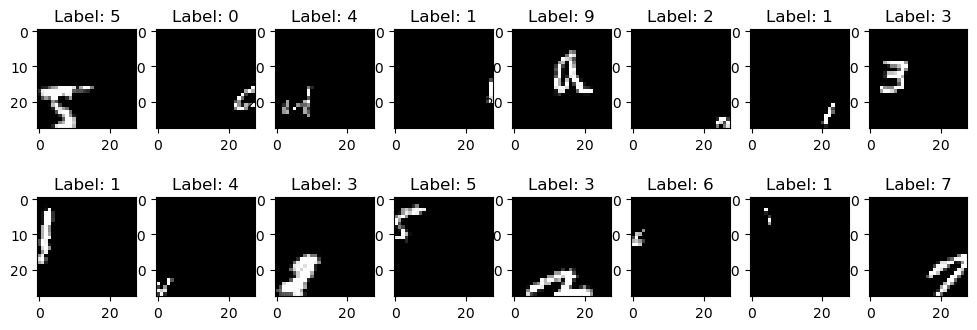

## Test Data

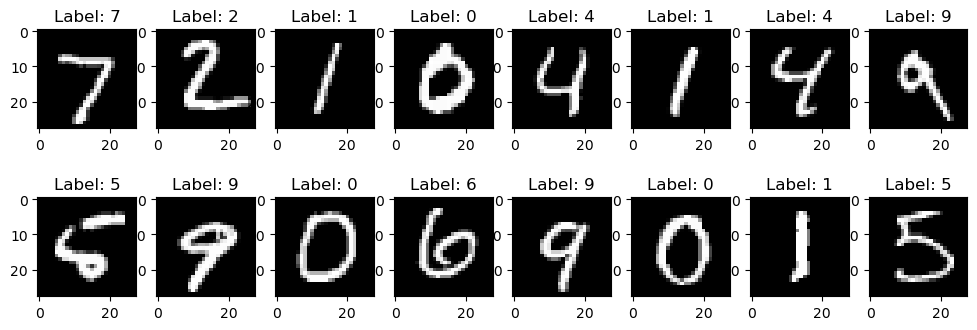

In [4]:
# Plot some digits.

def display_sample_data(data, data_label, rows=2, cols=8):
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(1.5*cols, 2*rows))
    for i, ax in enumerate(axes.flatten()):
        image, label = data[i]          # returns PIL image with its labels
        ax.set_title(f"Label: {label}")
        ax.imshow(image.squeeze(0), cmap='gray')  # we get a 1x28x28 tensor -> remove first dimension
    display_markdown(f"## {data_label}", raw=True)
    plt.show()

display_sample_data(mnist_training, 'Training Data')
display_sample_data(mnist_val, 'Test Data')

In [5]:
# Lib
def train(
    model: nn.Module, 
    train_loader: torch.utils.data.DataLoader, 
    device: torch.device, 
    optimizer: torch.optim.Optimizer, 
    epoch: int,
    bar: tqdm_notebook
):
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        imgs, labels = data.to(device), target.to(device)
        opt.zero_grad()
        predictions = model(imgs)
        # Compute the loss
        loss = loss_fn(predictions, labels)
        loss.backward()
        losses.append(float(loss))
        opt.step()
        bar.update(batch_size)
    return losses

def test(
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device,
    bar: tqdm
):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            img_grid = torchvision.utils.make_grid(data)
            output = model(data)
            test_loss += loss_fn(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            bar.update(test_batch_size)

In [6]:
torch.backends.cudnn.benchmark = True

model = CNN().to(device)

opt = torch.optim.Adadelta(params=model.parameters(), lr=learning_rate)

losses = []
test_losses = []

# progress bars
epoch_bar    = tqdm_notebook(position=1, total=num_epochs, bar_format="{desc} {bar} {elapsed}/{remaining}")
training_bar = tqdm_notebook(position=2, total=training_size, desc="Train", mininterval=0.05)
testing_bar  = tqdm_notebook(position=3, total=test_size,     desc="Test ")


scheduler = StepLR(opt, step_size=step_size, gamma=gamma)
for epoch in range(num_epochs):
    # update and reset progress bars
    epoch_bar.set_description_str(f'Epoch: {epoch}')
    training_bar.reset()
    testing_bar.reset()
    
    epoch_losses = train(model, train_loader, device, opt, epoch, bar=training_bar)
    test(model, test_loader, device, bar=testing_bar)
    losses.append(epoch_losses)
    
    epoch_bar.update(1)
    scheduler.step()
print('Training Finished')

            00:00/?

Train:   0%|          | 0/60000 [00:00<?, ?it/s]

Test :   0%|          | 0/10000 [00:00<?, ?it/s]

Training Finished


# Accuracy: 97.31%

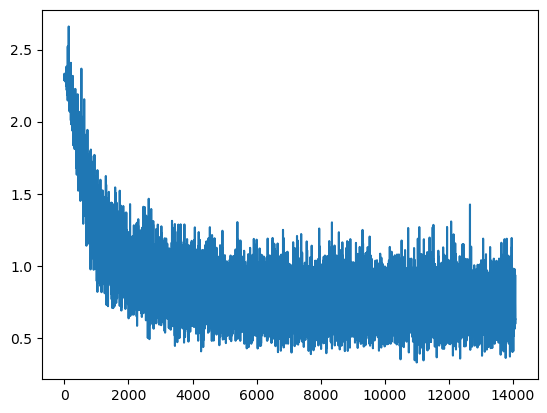

In [7]:
# Plot Learning Curve
plt.plot(list(flatten(losses)))

# Determine the accuracy of our clasifier
loader = torch.utils.data.DataLoader(mnist_val, batch_size=test_size, **loader_opts)
data, target = next(iter(loader))
images, labels = data.to(device), target.to(device)

predictions = model(images).to(device)

# For each row determine the column index with the maximum score. This is the
# predicted class.
predicted_classes = torch.argmax(predictions, dim=1)

# Accuracy = number of correctly classified images divided by the total number
# of classified images.
accuracy = sum(predicted_classes.cpu().numpy() == labels.cpu().numpy()) / test_size
display_markdown('# Accuracy: {:.2f}%'.format(100. * accuracy), raw=True)

In [9]:
# export to onnx format
def onnxExport(net: nn.Module, state_dict):
    pytorch_model = net(inference=True)
    pytorch_model.load_state_dict(state_dict)
    pytorch_model.eval()
    dummy_input = torch.zeros([280 * 280 * 4])
    torch.onnx.export(pytorch_model, dummy_input, './demo/models/mnist_inference_model.onnx', verbose=True, opset_version=9)


model_state = model.state_dict()
onnxExport(CNN, model_state)
print('model exported to demo/models/')

model exported to demo/modes/
